<a href="https://colab.research.google.com/github/rigonzal/ANN/blob/master/Approach2/Pregunta_1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF-395 Redes Neuronales Artificiales II-2018

## Tarea 2 - Redes Convolucionales y sus aplicaciones


26/11/2018

* Rodrigo González Smith 201303026-2
* Ignacio Valenzuela Albornoz

## Introducción



Débido al tema del trabajo usaremos **Keras** para la creación de las redes y su posterior entrenamiento/validación. Como también las librerías comunes de trabajo de Python:

In [0]:
#Correr solo en Colab
!pip install -q keras

In [0]:
import numpy as np   
import os   
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
import os
import h5py

%matplotlib inline

## 1. Convolutional Neural Networks (CNN) en CIFAR

Para esta primera parte del informe se trabajaran con los datos de CIFAR10, los cuales correspondes a imágenes las cuales tendremos que clasificar en sus cateogrías correspondientes. De esta manera usaremos CNN, las cuales son adecuadas y efectivas para este tipo de tareas.   

### 1.a) Exploración del Dataset

El data set cuenta con 60.000 imágenes con resolución 32x32, las cuales se clasifican en 10 categorías.  Las proporciones de los datos serán 40.000, 10.000 y 10.000 respectivamente para entrenamiento, validación y test.

In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']  
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Extraemos algunas imágenes para visualizar con sus respectivas etiquetas:

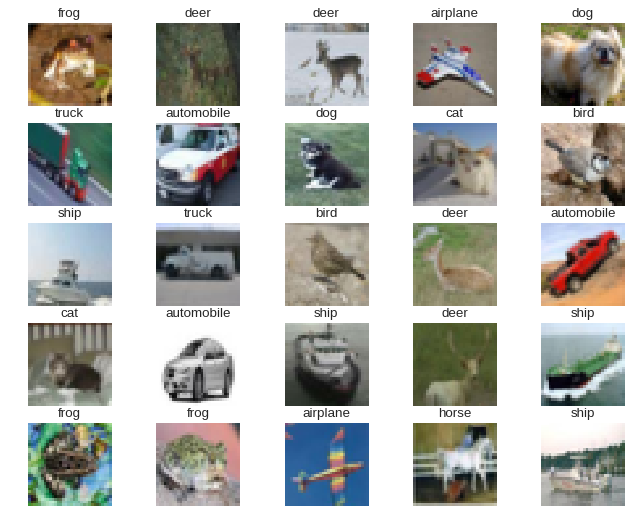

In [4]:
# Aumentamos el tamaño del plot
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

for i in range(25):  
  plt.subplot(5,5,i+1)
  plt.title(label_names[y_train[10*i][0]])
  plt.axis('off')
  _=plt.imshow(x_train[10*i])

La mala resolución se debe a los poco pixeles de la muestra, sin embargo para nuestros fines sera suficiente en el trabajo. Siguiente a esto separamos según como dijimos previamente los datos:

In [5]:
n_train = len(x_train)
x_val = x_train[int(0.8*n_train):n_train]
y_val = y_train[int(0.8*n_train):n_train]
x_train = x_train[:int(0.8*n_train)]
y_train = y_train[:int(0.8*n_train)]

print("Partición del dataset: ")
print("[Training]: " + str(len(x_train)))
print("[Validation]: " + str(len(x_val)))
print("[Test]: " + str(len(x_test)))

Partición del dataset: 
[Training]: 40000
[Validation]: 10000
[Test]: 10000


### 1.b) Preparación de dataset

Normalizamos los datos para que estén en el rango $x \in [0,1]$. En este caso, dado que son positivos al ser RGB. 

In [6]:
x_train_norm = x_train/255
x_val_norm = x_val/255
x_test_norm = x_test/255

num_classes = len(label_names)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Dimensión de cada fila: " + str(x_train_norm[0].shape))

Dimensión de cada fila: (32, 32, 3)


En donde la tercera columna corresponde a la codificación RGB o *channels*.    Por lo cual se estará usando el orden de TensorFlow para el ordenamiento de las dimensiones de las imagenes.

### 1.c) Definición CNN

Se define la red neuronal convolucional inicial a usar para la clasificación.  Se muestra un esquema respecto a la estructura interior de la red, con las dimensiones y sus cambios a medida que se avanza en ella. Notamos que antes de entrar a la capa densa de 512 neurona, se debe hacer un*flatten* del output de la anterior, con tal de que sea un vector de pesos el Input.



In [45]:
model_1_c = Sequential()
model_1_c.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_c.add(Activation('relu'))
model_1_c.add(MaxPooling2D(pool_size=(2, 2)))
model_1_c.add(Conv2D(64, (3, 3), padding='same'))
model_1_c.add(Activation('relu'))
model_1_c.add(MaxPooling2D(pool_size=(2, 2)))
model_1_c.add(Flatten())
model_1_c.add(Dense(512))
model_1_c.add(Activation('relu'))
model_1_c.add(Dense(10))
model_1_c.add(Activation('softmax'))
model_1_c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_120 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_121 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 4096)              0         
__________

### 1.d) Entrenamiento CNN

Para entrenar se usara el algoritmo del gradiente estocástico, con un momentum de 0.9. Además la tasa de apredizaje será cambiada manualmente, y estará en el rango $\eta \in [{10^{-3},10^{-5}}] $.  Esta se reduce a la mitad cada 10 épocas, el entrenamiento inicial se hizo con 25.

In [89]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((epoch)/10))
    lrate = max(lrate,0.00001)
    return lrate
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
batch_size = 1000
epochs = 25
model_1_c.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=["accuracy"] )
history_1_c = model_1_c.fit(x_train_norm, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val_norm,y_val), shuffle=True, callbacks=[lrate])

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 9s 218us/step - loss: 1.7968 - acc: 0.3780 - val_loss: 1.8131 - val_acc: 0.3695
Epoch 2/25
40000/40000 [==============================] - 5s 115us/step - loss: 1.7815 - acc: 0.3844 - val_loss: 1.7949 - val_acc: 0.3738
Epoch 3/25
40000/40000 [==============================] - 5s 116us/step - loss: 1.7688 - acc: 0.3862 - val_loss: 1.7778 - val_acc: 0.3797
Epoch 4/25
40000/40000 [==============================] - 5s 116us/step - loss: 1.7507 - acc: 0.3941 - val_loss: 1.7652 - val_acc: 0.3819
Epoch 5/25
40000/40000 [==============================] - 5s 116us/step - loss: 1.7348 - acc: 0.3984 - val_loss: 1.7521 - val_acc: 0.3888
Epoch 6/25
40000/40000 [==============================] - 5s 115us/step - loss: 1.7213 - acc: 0.4052 - val_loss: 1.7372 - val_acc: 0.3965
Epoch 7/25
40000/40000 [==============================] - 5s 115us/step - loss: 1.7062 - acc: 0.4091 - val_loss: 1.7189 - 

Con la red ya entrenada, se grafica la perdida de training contra la validación, para de esta manera tener una visión más general de la tendencia en el proceso de entrenamiento:

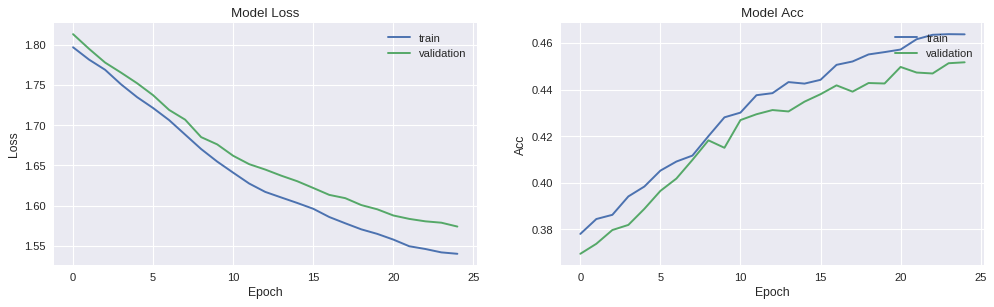

In [90]:
plt.figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(history_1_c.history['loss'])
plt.plot(history_1_c.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.subplot(1,2,2)
plt.plot(history_1_c.history['acc'])
plt.plot(history_1_c.history['val_acc'])
plt.title('Model Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Notamos entonces que el error podría haber seguido disminuyendo si se entrenaban algunas épocas más, sin embargo  en la validación ya estaba mostrando tendencias a separarse. Por lo cual puede que se empezara a "estancar" después de algunas épocas más o seguir cercano al *loss* de entrenamiento. Por otro lado el *accurcay* logrado es bajo, tanto por la arquitectura de la red, épocas y el optimizador de la red.

### 1.e)  RMSProp

Ahora entrenaremos la red con RMSProp,  el cual reduce la tasa de aprendizaje o *learning rate* a medida que avanzan las épocas de entrenamiento,  adaptandolo según la acumulación de valores anteriores de los gradientes descendientes. Donde por defecto se usará $\gamma  = 0.9$, el cual controla el largo de la escala de los promedios moviles. La idea de usar estos promedios moviles, es que la división de la tasa de aprendizaje se haga por números similares, entre *batches* adyacentes. Calcularemos el error de training, validación y test:


In [58]:
#función necesaria para obtener también el error de test
def get_metrics(model, data, epochs, batchs, lrate=None,verbos=1):
  history = list()
  history_test = list()
  for i in range(epochs):
    print("Epoch " + str(i+1) +"/" + str(epochs))
    if lrate == None:
      his = model.fit(data[0], data[1],batch_size=batchs,epochs=1,verbose=verbos , validation_data=(data[2],data[3]), shuffle=True)
    else:
      his = model.fit(data[0], data[1],batch_size=batchs,epochs=1,verbose=verbos ,validation_data=(data[2],data[3]), shuffle=True,callbacks=[lrate])
    history.append(his)
    loss, acc = model.evaluate(data[4],data[5],verbose=verbos)
    history_test.append([loss,acc])
    print("[TEST]: loss=" + str(loss) + ", acc= "+ str(acc))
  return history,history_test



#se define el modelo
model_1_e = Sequential()
model_1_e.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_e.add(Activation('relu'))
model_1_e.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e.add(Conv2D(64, (3, 3), padding='same'))
model_1_e.add(Activation('relu'))
model_1_e.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e.add(Flatten())
model_1_e.add(Dense(512))
model_1_e.add(Activation('relu'))
model_1_e.add(Dense(10))
model_1_e.add(Activation('softmax'))

#se agrega optimizador
opt = rmsprop(lr=0.001, decay=1e-6)
batch_size = 1000
epochs = 25
model_1_e.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'] )

#se agrega a una lista todos los datos para evitar funciones engorrosas, lo cual servirá para futuras ejecuciones
data = [x_train_norm, y_train, x_val_norm, y_val, x_test_norm, y_test]


history_1_e, history_1_e_test= get_metrics(model_1_e, data, epochs, batch_size,verbos=2)

Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 - 7s - loss: 2.1672 - acc: 0.2356 - val_loss: 1.8269 - val_acc: 0.3874
[TEST]: loss=1.8189788749694824, acc= 0.3944
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 1.7693 - acc: 0.3779 - val_loss: 1.7480 - val_acc: 0.3778
[TEST]: loss=1.7374270614624023, acc= 0.3785
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 1.5593 - acc: 0.4541 - val_loss: 1.7988 - val_acc: 0.3803
[TEST]: loss=1.7868058959960937, acc= 0.3875
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 1.4525 - acc: 0.4994 - val_loss: 1.2889 - val_acc: 0.5619
[TEST]: loss=1.2702678319931031, acc= 0.5607
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 1.3373 - acc: 0.5364 - val_loss: 1.2417 - val_acc: 0.5685
[TEST]: loss=1.2302003206253052, acc= 0.5624
Epoch 6/25
Train on 40000 samples, validate on 10000 samples

[[2.1672135084867477], [1.7692523568868637], [1.5592776834964752], [1.452489510178566], [1.3372965812683106], [1.2507514953613281], [1.177233597636223], [1.118979847431183], [1.0613504648208618], [1.0093150734901428], [0.9748194366693497], [0.9246736630797386], [0.89265126734972], [0.8484399884939193], [0.8076750829815864], [0.7734957337379456], [0.7500114053487777], [0.6956166416406632], [0.6625661894679069], [0.6346469566226005], [0.5906868480145931], [0.5567079037427902], [0.5177602171897888], [0.4836516723036766], [0.4571927644312382]]


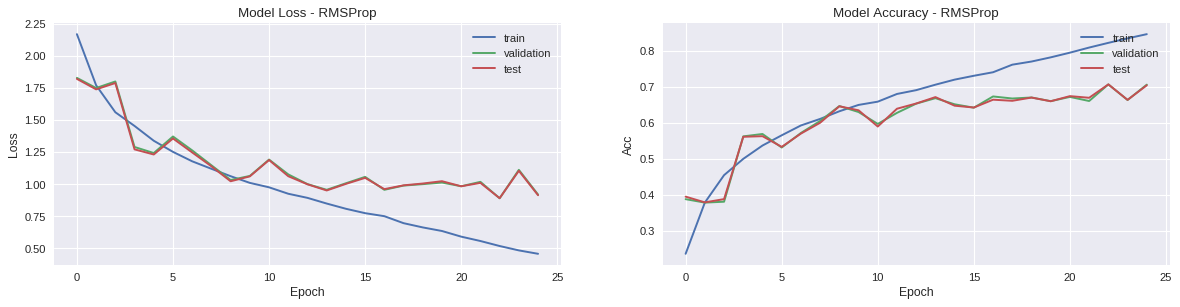

In [111]:
#definimos funciones que ayudaran a modularizar y evitar redundancia de codigo

def get_metrics_lists(history,history_test):
  loss_train,loss_val,loss_test,acc_train,acc_val,acc_test = list(),list(),list(),list(),list(),list()
  losses = [[] for i in range(3)]
  accs = [[] for i in range(3)]
  for i in range(len(history)):
    loss_train,loss_val,loss_test,acc_train,acc_val,acc_test = history[i].history['loss'],history[i].history['val_loss'],history_test[i][0], history[i].history['acc'],history[i].history['val_acc'],history_test[i][1]
    losses[0].append(loss_train)
    losses[1].append(loss_val)
    losses[2].append(loss_test)
    accs[0].append(acc_train)
    accs[1].append(acc_val)
    accs[2].append(acc_test)
  return losses,accs

def triple_plot(losses, accs,title):
  plt.figure(num=None, figsize=(18, 4), dpi=80, facecolor='w', edgecolor='k')
  plt.subplot(1,2,1)
  plt.plot(losses[0])
  plt.plot(losses[1])
  plt.plot(losses[2])
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation','test'], loc='upper right')
  plt.subplot(1,2,2)
  plt.plot(accs[0])
  plt.plot(accs[1])
  plt.plot(accs[2])
  plt.title(title.replace("Loss", "Accuracy"))
  plt.xlabel('Epoch')
  plt.ylabel('Acc')
  plt.legend(['train', 'validation','test'], loc='upper right')
  
  plt.show()
  
losses = list()
losses,accs = get_metrics_lists(history_1_e,history_1_e_test)
 
triple_plot(losses,accs,'Model Loss - RMSProp')

Un claro caso de Overfitting en el modelo al usar RMSProp,  sin embargo el valor al  que se empezó a llegar en la valdación y test es menor que haciendo una reducción manual del *learning rate*. Es por lo cual que repetiremos pero probando con una reducción de este problema usando Dropout, así la red no tenderá a crear conexiones demasiado complejas, al obligar a que use otros pesos.

Epoch 1/25
[TEST]: loss=1.8802028842926026, acc= 0.3178
Epoch 2/25
[TEST]: loss=1.5933028882980347, acc= 0.4333
Epoch 3/25
[TEST]: loss=1.489202742767334, acc= 0.477
Epoch 4/25
[TEST]: loss=1.291124485206604, acc= 0.5519
Epoch 5/25
[TEST]: loss=1.1855360925674439, acc= 0.5845
Epoch 6/25
[TEST]: loss=1.2643453985214232, acc= 0.55
Epoch 7/25
[TEST]: loss=1.2023223184585572, acc= 0.5831
Epoch 8/25
[TEST]: loss=1.4760499824523925, acc= 0.4986
Epoch 9/25
[TEST]: loss=1.0721625255584717, acc= 0.6275
Epoch 10/25
[TEST]: loss=1.052546426963806, acc= 0.63
Epoch 11/25
[TEST]: loss=1.211158720779419, acc= 0.577
Epoch 12/25
[TEST]: loss=1.080272466468811, acc= 0.6205
Epoch 13/25
[TEST]: loss=0.9409833196640015, acc= 0.6735
Epoch 14/25
[TEST]: loss=1.0771719818115235, acc= 0.631
Epoch 15/25
[TEST]: loss=0.9625650959014893, acc= 0.6721
Epoch 16/25
[TEST]: loss=0.9452951577186585, acc= 0.6752
Epoch 17/25
[TEST]: loss=0.9792240339279175, acc= 0.6678
Epoch 18/25
[TEST]: loss=0.9223553994178771, acc= 0.

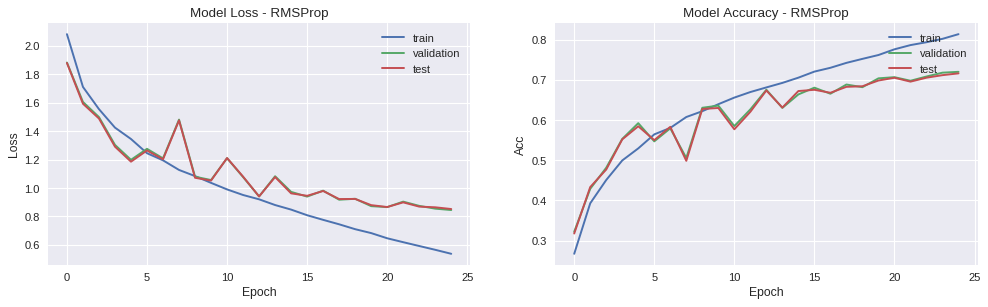

In [77]:
model_1_e_drop = Sequential()
model_1_e_drop.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_e_drop.add(Activation('relu'))
model_1_e_drop.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e_drop.add(Conv2D(64, (3, 3), padding='same'))
model_1_e_drop.add(Activation('relu'))
model_1_e_drop.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e_drop.add(Dropout(0.25))
model_1_e_drop.add(Flatten())
model_1_e_drop.add(Dense(512))
model_1_e_drop.add(Activation('relu'))
model_1_e_drop.add(Dropout(0.25))
model_1_e_drop.add(Dense(10))
model_1_e_drop.add(Activation('softmax'))

opt = rmsprop(lr=0.001, decay=1e-6)
batch_size = 1000
epochs = 25
model_1_e_drop.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'] )
history_1_e_drop, history_1_e_drop_test= get_metrics(model_1_e_drop, data, epochs, batch_size,verbos=0)
losses, accs = get_metrics_lists(history_1_e_drop,history_1_e_drop_test)
triple_plot(losses,accs,'Model Loss - RMSProp')


Como se puede ver se empezó a reducir el Overfitting añadiendo 2 capas de Droput, sin embargo todavía hay cambios que se pueden hacer en el modelo de manera general con el fin de evitar este fenómeno y también mejorar los indices que se obtienen. 

Para los siguientes enunciados usaremos la red con el optimizador SGD junto al *step decay* o *Learning rate scheduler*, dado que a pesar de los mejores resultados con *Dropout*, para poder comparar adecuadamente los métodos y gracias a que los resultados son menos variables será más adecuado usar la red del inciso d).

-----
### 1.f) Variación tamaño filtros de convolución

Se modifica el tamaño de los filtros, posteriormente se debe analizar su error antes estos cambios. Lo anterior se realizará para una red *shallow*/poco profunda y una *deep*/profunda. Finalmente se compara los errores para comentar. Se seguirá usando RMSProp por los buenos y mejores resultados obtenidos en vez de usar gradiente estocastico como optimizador.

#### 1.f.1) Shallow network

Procedemos a entrenar una red *shallow*, dado que serán menos parámetros evitaremos usar dropout para ver el comportamiento.

In [92]:
models_1_f_shallow = list()
histories_1_f_shallow = list()
histories_1_f_shallow_test = list()
for i in range(3):

    """Shallow network"""
    nc = i+2 #convolutional filter size
    models_1_f_shallow.append(Sequential())
    models_1_f_shallow[i].add(Conv2D(64, (nc,nc), padding='same', input_shape=x_train.shape[1:]))
    models_1_f_shallow[i].add(Activation('relu'))
    models_1_f_shallow[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_f_shallow[i].add(Flatten())
    models_1_f_shallow[i].add(Dense(512))
    models_1_f_shallow[i].add(Activation('relu'))
    models_1_f_shallow[i].add(Dense(10))
    models_1_f_shallow[i].add(Activation('softmax'))

    #opt = rmsprop(lr=0.001, decay=1e-6)
    opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
    batch_size = 1000
    epochs = 20
    models_1_f_shallow[i].compile(loss="categorical_crossentropy" , optimizer=opt,metrics=['accuracy'] )

    history_1_f_shallow, history_1_f_shallow_test = get_metrics(models_1_f_shallow[i], data, epochs, batch_size,lrate=lrate,verbos=0)
    histories_1_f_shallow.append(history_1_f_shallow)
    histories_1_f_shallow_test.append(history_1_f_shallow_test)

Epoch 1/20
[TEST]: loss=2.2538342235565185, acc= 0.1857
Epoch 2/20
[TEST]: loss=2.2040370655059816, acc= 0.2521
Epoch 3/20
[TEST]: loss=2.1510273849487302, acc= 0.2671
Epoch 4/20
[TEST]: loss=2.099935320663452, acc= 0.2993
Epoch 5/20
[TEST]: loss=2.0540681718826295, acc= 0.3002
Epoch 6/20
[TEST]: loss=2.013768721008301, acc= 0.3108
Epoch 7/20
[TEST]: loss=1.9793647331237794, acc= 0.3227
Epoch 8/20
[TEST]: loss=1.9499265941619872, acc= 0.3337
Epoch 9/20
[TEST]: loss=1.9258337656021118, acc= 0.3426
Epoch 10/20
[TEST]: loss=1.9063713474273682, acc= 0.3429
Epoch 11/20
[TEST]: loss=1.8886244514465331, acc= 0.3532
Epoch 12/20
[TEST]: loss=1.8737620401382447, acc= 0.3579
Epoch 13/20
[TEST]: loss=1.8597946273803712, acc= 0.3578
Epoch 14/20
[TEST]: loss=1.8476222911834717, acc= 0.3652
Epoch 15/20
[TEST]: loss=1.8366503395080567, acc= 0.3696
Epoch 16/20
[TEST]: loss=1.8243448049545288, acc= 0.3734
Epoch 17/20
[TEST]: loss=1.8141281480789184, acc= 0.3781
Epoch 18/20
[TEST]: loss=1.803158108901977

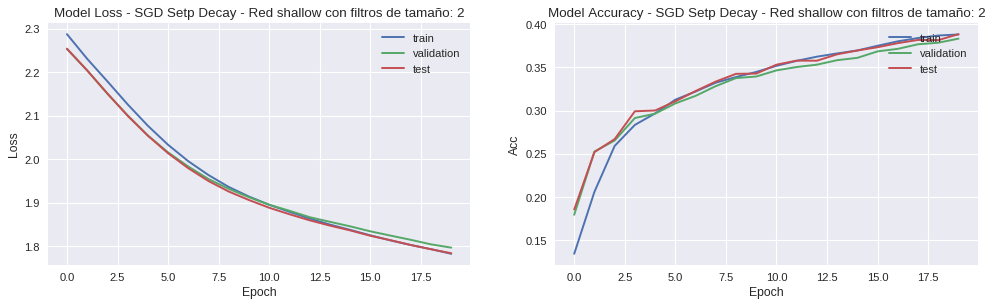

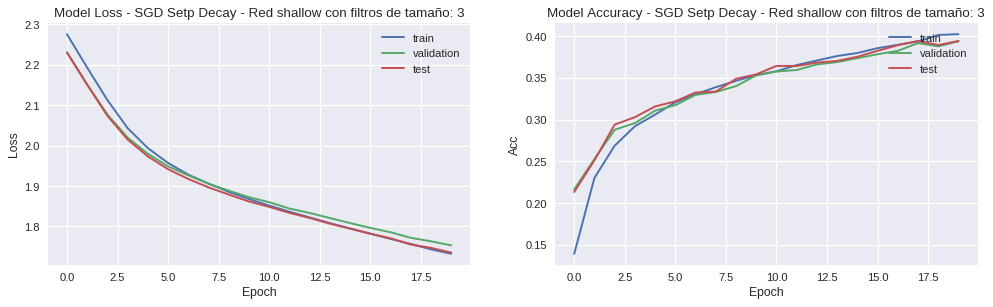

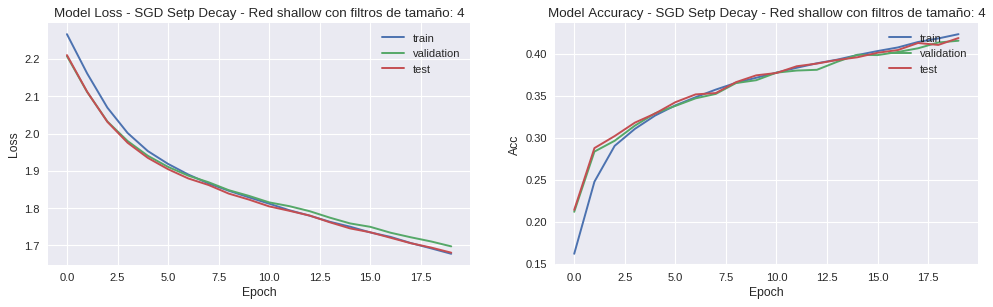

In [99]:
#ploteo de 3 modelos shallow con distintos filtros convolucionales
losses_list = list()
accs_list = list()
for i in range(3):
  losses, accs = get_metrics_lists(histories_1_f_shallow[i],histories_1_f_shallow_test[i])
  losses_list.append(losses)
  accs_list.append(accs)
  triple_plot(losses, accs, "Model Loss - SGD Setp Decay - Red shallow con filtros de tamaño: " +  str(i+2))

#### 1.f.2) Dense network

Para este caso usaremos una red densa con la arquitectura: $C \times P \times C \times P \times C \times P   \times F \times F$ y de esta manera entrenaremos para posteriormente comparar con la red *shallow* previamente usada en la clasificación.

In [96]:
models_1_f_dense = list()
histories_1_f_dense = list()
histories_1_f_dense_test = list()
for i in range(3):

    """dense network"""
    nc = i+2 #convolutional filter size
    models_1_f_dense.append(Sequential())
    models_1_f_dense[i].add(Conv2D(64, (nc,nc), padding='same', input_shape=x_train.shape[1:]))
    models_1_f_dense[i].add(Activation('relu'))
    models_1_f_dense[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_f_dense[i].add(Conv2D(64, (nc,nc), padding='same'))
    models_1_f_dense[i].add(Activation('relu'))
    models_1_f_dense[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_f_dense[i].add(Conv2D(64, (nc,nc), padding='same'))
    models_1_f_dense[i].add(Activation('relu'))
    models_1_f_dense[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_f_dense[i].add(Flatten())
    models_1_f_dense[i].add(Dense(512))
    models_1_f_dense[i].add(Activation('relu'))
    models_1_f_shallow[i].add(Dropout(0.25))
    models_1_f_dense[i].add(Dense(10))
    models_1_f_dense[i].add(Activation('softmax'))
    
    opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
    #opt = rmsprop(lr=0.001, decay=1e-6)
    batch_size = 1000
    epochs = 20
    models_1_f_dense[i].compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'] )

    history_1_f_dense, history_1_f_dense_test = get_metrics(models_1_f_dense[i], data, epochs, batch_size, lrate=lrate)
    histories_1_f_dense.append(history_1_f_dense)
    histories_1_f_dense_test.append(history_1_f_dense_test)

Epoch 1/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 142us/step
[TEST]: loss=2.2974140411376953, acc= 0.1017
Epoch 2/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 143us/step
[TEST]: loss=2.2923014877319337, acc= 0.1238
Epoch 3/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 141us/step
[TEST]: loss=2.2874103286743166, acc= 0.158
Epoch 4/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 141us/step
[TEST]: loss=2.2821015808105467, acc= 0.1755
Epoch 5/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 144us/step
[TEST]: loss=2.2761239635467527, acc= 0.1801
Epoch 6/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] 

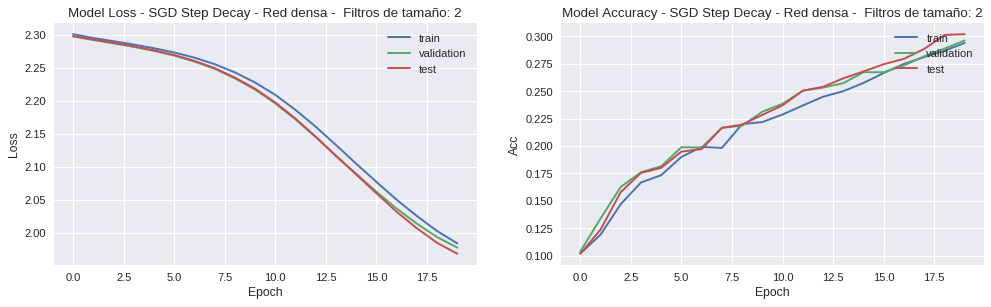

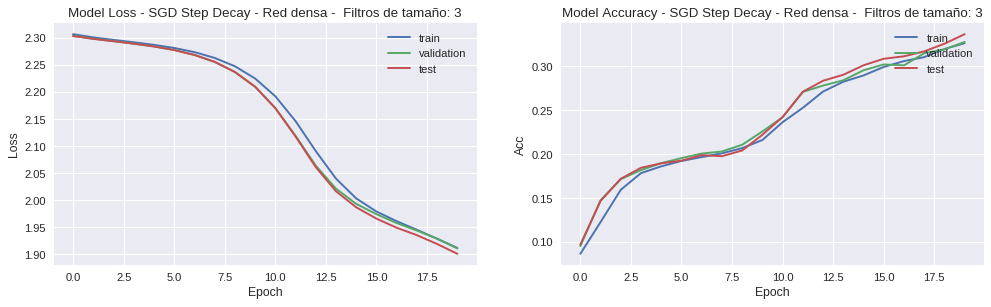

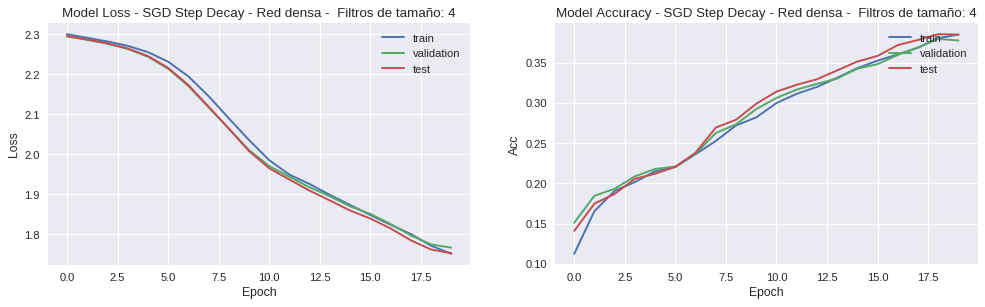

In [98]:
#ploteo de 3 modelos dense con distintos filtros convolucionales
losses_list_1_f_dense = list()
accs_list_1_f_dense = list()
for i in range(3):
  losses, accs = get_metrics_lists(histories_1_f_dense[i],histories_1_f_dense_test[i])
  losses_list_1_f_dense.append(losses)
  accs_list_1_f_dense.append(accs)
  triple_plot(losses, accs, "Model Loss - SGD Step Decay - Red profunda -  Filtros de tamaño: " +  str(i+2))
 



La red *shallow* obtuvo resultados ligeramente mejores, siendo de manera general bajos en el objetvo final de la red. Por otro lado se pudo notar que se mejoraron levemento los indices de error y *accuracy* al aumentar el tamaño de los filtros utilizados.

----
### 1.g) Variación filtros de convolución

Ahora procederemos a probar el desempeño de una red neuronal con Pooling y otra con menor cantidad, esto para poder analizar los efectos de evitar una reducción dimensional rápidamente en la red. Por otro lado usaremos la propoción de 64 filtros para doblar a 128 entre la(s) primera(s) capa(s) y la(s) segunda(s).

#### 1.g.1) Arquitectura con Pooling después de cada capa convolucional

Se usará la siguiente arquitectura $C \times P \times C \times P \times F \times F$

In [101]:
models_1_g = list()
histories_1_g = list()
histories_1_g_test = list()
for i in range(3):
    """dense network"""
    nc = 3 #convolutional filter size
    aux = nc
    models_1_g.append(Sequential())
    if i == 2:
      aux=5
    models_1_g[i].add(Conv2D(64, (aux,aux), padding='same', input_shape=x_train.shape[1:]))
    aux=nc
    models_1_g[i].add(Activation('relu'))
    models_1_g[i].add(MaxPooling2D(pool_size=(2, 2)))
    if i == 1:
        aux=5
    models_1_g[i].add(Conv2D(128, (aux,aux), padding='same'))
    models_1_g[i].add(Activation('relu'))
    models_1_g[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_g[i].add(Flatten())
    models_1_g[i].add(Dense(512))
    models_1_g[i].add(Activation('relu'))
    models_1_g[i].add(Dense(10))
    models_1_g[i].add(Activation('softmax'))

    opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
    epochs = 25
    models_1_g[i].compile(loss="categorical_crossentropy" , optimizer=opt ,metrics=['accuracy'])
    history_1_g, history_1_g_test = get_metrics(models_1_g[i], data, epochs, batch_size,lrate=lrate)
    histories_1_g.append(history_1_g)
    histories_1_g_test.append(history_1_g_test)


Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 157us/step
[TEST]: loss=2.271052300262451, acc= 0.1567
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 154us/step
[TEST]: loss=2.2386913867950438, acc= 0.2116
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 155us/step
[TEST]: loss=2.197075975036621, acc= 0.2492
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 157us/step
[TEST]: loss=2.1461703800201417, acc= 0.2728
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 156us/step
[TEST]: loss=2.095042204284668, acc= 0.2829
Epoch 6/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 

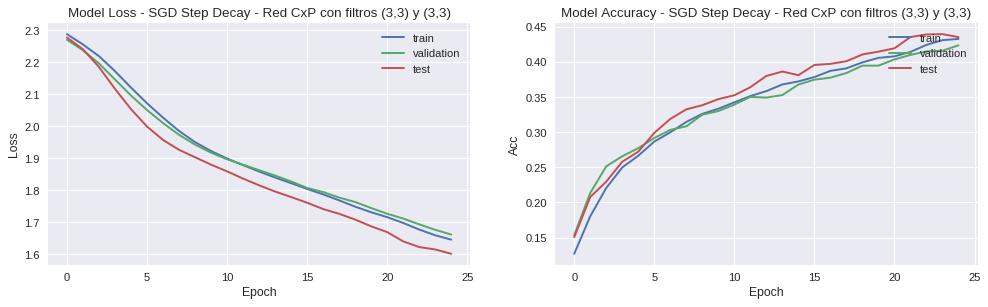

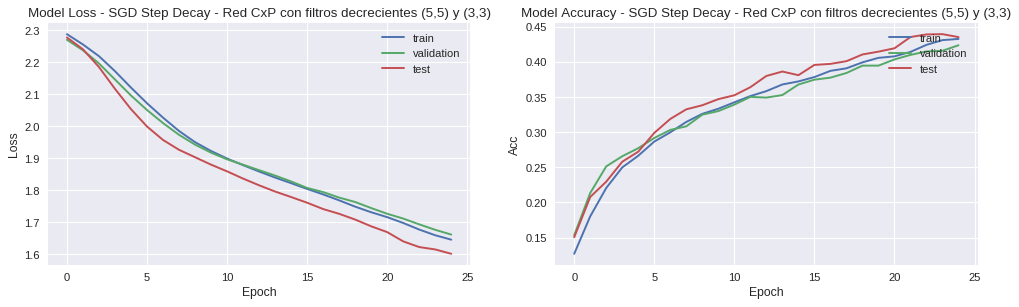

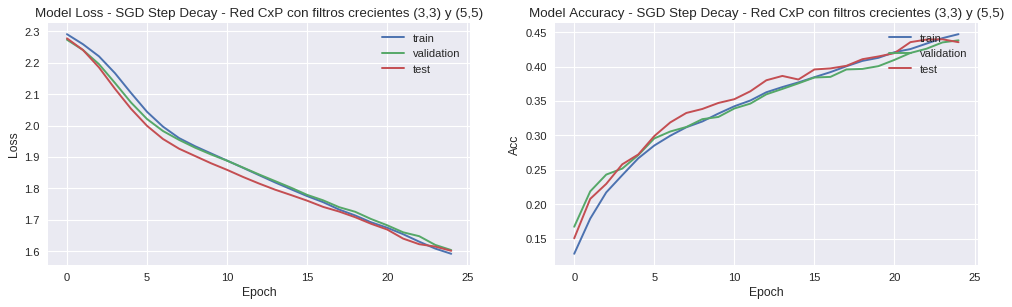

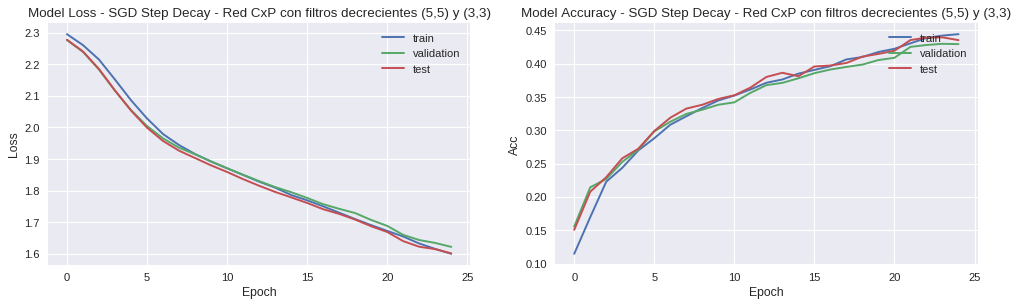

In [103]:
losses_list_1_g = list()
accs_list_1_g = list()
for i in range(3):
  losses, accs = get_metrics_lists(histories_1_g[i],history_1_g_test)
  losses_list_1_g.append(losses)
  accs_list_1_g.append(accs)
  if i == 0:
      triple_plot(losses, accs,'Model Loss - SGD Step Decay - Red CxP con filtros (3,3) y (3,3)')
  if i == 1:
      triple_plot(losses, accs,'Model Loss - SGD Step Decay - Red CxP con filtros crecientes (3,3) y (5,5)')
  else:
      triple_plot(losses, accs,'Model Loss - SGD Step Decay - Red CxP con filtros decrecientes (5,5) y (3,3)')

#### 1.g.2) Arquitectura con Pooling después de 2 capas convolucionales   

Se usará la siguiente arquitectura:  $C \times C \times P \times C \times C \times P \times F \times F$. Con 64 filtros para las primeras 2 capas Conv. y 128 para las 2 siguientes.


In [106]:
models_1_g_nopool = list()
histories_1_g_nopool = list()
histories_1_g_nopool_test = list()
for i in range(3):
    """dense network"""
    nc = 3 #convolutional filter size
    aux = nc
    models_1_g_nopool.append(Sequential())
    if i == 2:
      aux = 5
    models_1_g_nopool[i].add(Conv2D(64, (aux,aux), padding='same', input_shape=x_train.shape[1:]))
    models_1_g_nopool[i].add(Activation('relu'))
    models_1_g_nopool[i].add(Conv2D(64, (aux,aux), padding='same', input_shape=x_train.shape[1:]))
    models_1_g_nopool[i].add(Activation('relu'))
    models_1_g_nopool[i].add(MaxPooling2D(pool_size=(2, 2)))
    aux = nc
    if i == 1:
      aux = 5
    models_1_g_nopool[i].add(Conv2D(128, (aux,aux), padding='same'))
    models_1_g_nopool[i].add(Activation('relu'))
    models_1_g_nopool[i].add(Conv2D(128, (aux,aux), padding='same'))
    models_1_g_nopool[i].add(Activation('relu'))
    models_1_g_nopool[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_g_nopool[i].add(Flatten())
    models_1_g_nopool[i].add(Dense(512))
    models_1_g_nopool[i].add(Activation('relu'))
    models_1_g_nopool[i].add(Dense(10))
    models_1_g_nopool[i].add(Activation('softmax'))

    opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
    lrate = LearningRateScheduler(step_decay)
    epochs = 25
    models_1_g_nopool[i].compile(loss="categorical_crossentropy" , optimizer=opt ,metrics=['accuracy'])
    history_1_g_nopool, history_1_g_nopool_test = get_metrics(models_1_g_nopool[i], data, epochs, batch_size, lrate=lrate)
    histories_1_g_nopool.append(history_1_g_nopool)
    histories_1_g_nopool_test.append(history_1_g_nopool_test)

Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 228us/step
[TEST]: loss=2.2955352352142335, acc= 0.1486
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 232us/step
[TEST]: loss=2.2861987464904785, acc= 0.132
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 234us/step
[TEST]: loss=2.273094067764282, acc= 0.1388
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 231us/step
[TEST]: loss=2.250727025985718, acc= 0.1819
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 230us/step
[TEST]: loss=2.207705825805664, acc= 0.2075
Epoch 6/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2

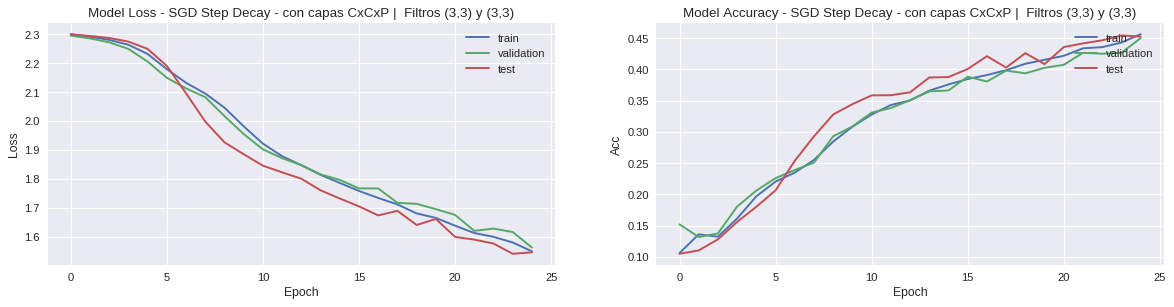

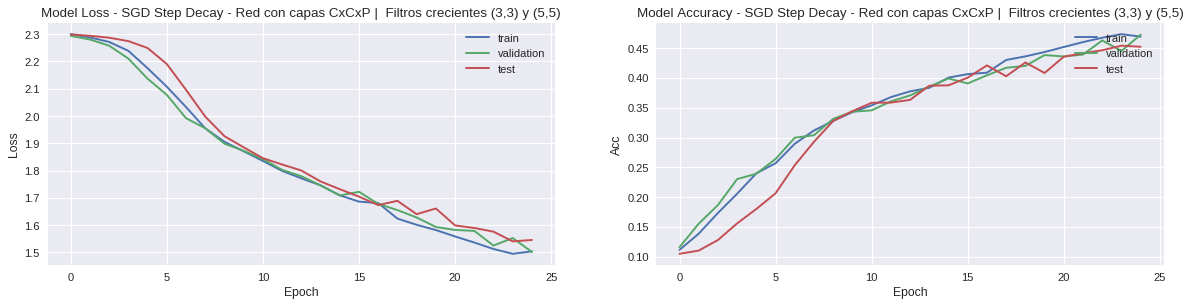

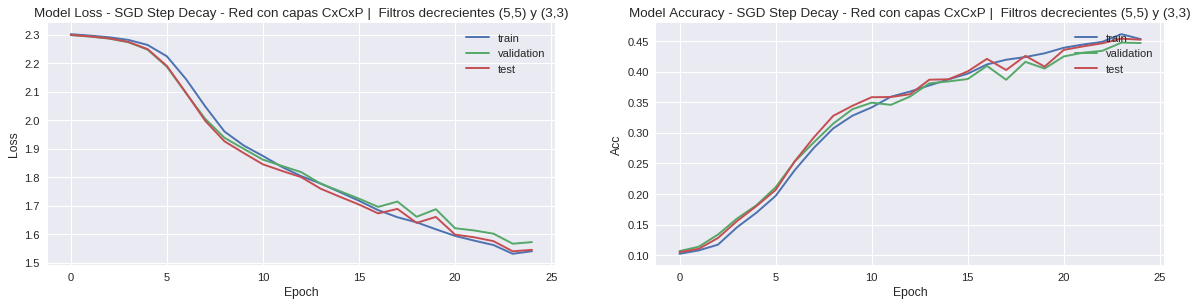

In [112]:
losses_list_1_g_nopool = list()
accs_list_1_g_nopool = list()
for i in range(3):
  losses, accs = get_metrics_lists(histories_1_g_nopool[i],history_1_g_nopool_test)
  losses_list_1_g_nopool.append(losses)
  accs_list_1_g_nopool.append(accs)
  if i == 0:
      triple_plot(losses, accs,'Model Loss - SGD Step Decay - con capas CxCxP |  Filtros (3,3) y (3,3)')
  if i == 1:
      triple_plot(losses, accs,'Model Loss - SGD Step Decay - Red con capas CxCxP |  Filtros crecientes (3,3) y (5,5)')
  if i == 2:
      triple_plot(losses, accs,'Model Loss - SGD Step Decay - Red con capas CxCxP |  Filtros decrecientes (5,5) y (3,3)')

------
### 1.h)  Convolución con stride

Ahora se verificará si efectivamente existe una reducción dimensional al usar *stride* en las capas convolucionales. 

In [118]:
model_1_h = Sequential()
model_1_h.add(Conv2D(128, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model_1_h.add(Activation('relu'))
model_1_h.add(Conv2D(128, (3, 3), padding='same'))
model_1_h.add(Activation('relu'))
model_1_h.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
model_1_h.add(Activation('relu'))
model_1_h.add(Flatten())
model_1_h.add(Dense(512))
model_1_h.add(Activation('relu'))
model_1_h.add(Dense(10))
model_1_h.add(Activation('softmax'))
model_1_h.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_252 (Activation)  (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 32, 32, 128)       147584    
_________________________________________________________________
activation_253 (Activation)  (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 16, 16, 64)        73792     
_________________________________________________________________
activation_254 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_65 (Flatten)         (None, 16384)             0         
__________

Efectivamente la dimensión de output se reduce a la mitad al igual que hacer un *Pooling* de 2x2, esto debido a la manera en la cual se realiza la convolución con *stride=2*, el cual no hace un "traslape" entre cada multiplicación. 

Se procede a entrenar la red y ver su error como también el *accuracy* al que llega con este nuevo tipo de reducción dimensional.

Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 321us/step
[TEST]: loss=2.286032634735107, acc= 0.1161
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 306us/step
[TEST]: loss=2.2570985218048096, acc= 0.1311
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 306us/step
[TEST]: loss=2.1925386039733885, acc= 0.2149
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 308us/step
[TEST]: loss=2.079236248397827, acc= 0.2651
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 305us/step
[TEST]: loss=1.9780175930023194, acc= 0.3075
Epoch 6/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] -

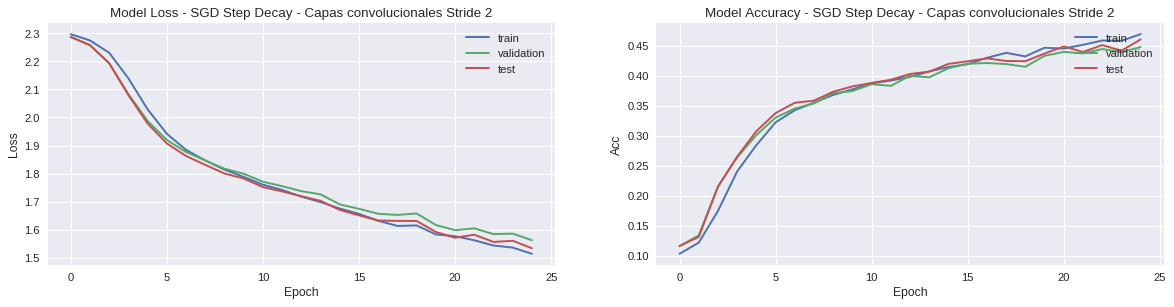

In [119]:
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
batch_size = 1000
epochs = 25
model_1_h.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'])
history_1_h, history_1_h_test = get_metrics(model_1_h, data, epochs, batch_size,lrate=lrate,verbos=1)
losses_1_h, accs_1_h = get_metrics_lists(history_1_h,history_1_h_test) 
triple_plot(losses_1_h, accs_1_h,'Model Loss - SGD Step Decay - Capas convolucionales Stride 2')


-----
### 1.i) Aumento del dataset

Ahora probaremos creando más datos a partir de los existentes agregando ruido a las imágenes. Esto con el fin de crear una red más robusta en la clasificación, ahora se verá el resultado de entrenar con estos datos. Para ello usaremos una red 

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)

In [130]:
model_1_i = Sequential()
model_1_i.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_i.add(Activation('relu'))
model_1_i.add(MaxPooling2D(pool_size=(2, 2)))
model_1_i.add(Conv2D(64, (3, 3), padding='same'))
model_1_i.add(Activation('relu'))
model_1_i.add(MaxPooling2D(pool_size=(2, 2)))
model_1_i.add(Flatten())
model_1_i.add(Dense(512))
model_1_i.add(Activation('relu'))
model_1_i.add(Dense(10))
model_1_i.add(Activation('softmax'))
model_1_i.summary()

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
batch_size = 1000
epochs = 25
model_1_i.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'])

history_1_i = model_1_i.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),steps_per_epoch=x_train.shape[0]//
                                      batch_size, epochs=epochs,validation_data=(x_test, y_test))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_261 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_262 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_67 (Flatten)         (None, 4096)              0         
__________

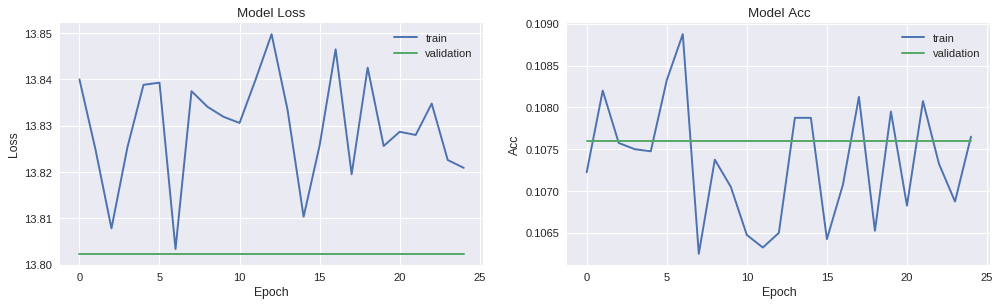

In [131]:
plt.figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(history_1_i.history['loss'])
plt.plot(history_1_i.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.subplot(1,2,2)
plt.plot(history_1_i.history['acc'])
plt.plot(history_1_i.history['val_acc'])
plt.title('Model Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

-----
### 1.j) Opencv

In [93]:
!pip install opencv-python==3.1.0.4 opencv-contrib-python==3.4.2.16

  Could not find a version that satisfies the requirement opencv-python==3.1 (from versions: 3.1.0.4, 3.1.0.5, 3.2.0.6, 3.2.0.7, 3.2.0.8, 3.3.0.9, 3.3.0.10, 3.3.1.11, 3.4.0.12, 3.4.0.14, 3.4.1.15, 3.4.2.16, 3.4.2.17, 3.4.3.18)
No matching distribution found for opencv-python==3.1


In [0]:
import cv2
def pre_process(img):
    if np.max(img) <= 1:
        img*=255
    img = img.astype("uint8")
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_gray
def calculate_sift(cifar):
    sift_cifar = []
    for image in cifar:
      img_gray = pre_process(image)
      sift = cv2.xfeatures2d.SIFT_create()
      kp, desc = sift.detectAndCompute(img_gray, None)
      if type(desc) == type(None):
        desc = np.zeros((1,128))
      compress_desc = np.mean(desc,axis=0) #compress all keypoints
      sift_cifar.append(compress_desc)
    return np.asarray(sift_cifar)
cifar_sift = calculate_sift(X)

-----
### 1.k) Aumento del dataset

-----
### 1.l) Aumento del dataset